# MNIST Classification Baseline
## Nhận dạng chữ số viết tay

Notebook này cung cấp một baseline đơn giản cho bài toán phân loại chữ số viết tay MNIST.

**Mục tiêu**: Train mô hình để dự đoán chữ số (0-9) từ ảnh viết tay

**Dữ liệu**:
- Train: 60,000 ảnh với label
- Public Test: 10,000 ảnh cần dự đoán

**Output**: File CSV với 2 cột image_name và label

## 1. Import thư viện

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [2]:
import torch

print("="*60)
print("GPU INFORMATION")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print("\n✅ GPU is ready to use!")
else:
    print("\n⚠️ GPU not available")
print("="*60)

GPU INFORMATION
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU
GPU Memory: 6.00 GB

✅ GPU is ready to use!


In [3]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Load và khám phá dữ liệu

In [4]:
TRAIN_DIR = 'mnist_competition/train'
TEST_DIR = 'mnist_competition/public_test'
TRAIN_CSV = 'mnist_competition/train_label.csv'
TEST_CSV = 'mnist_competition/public_test.csv'

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f'Train samples: {len(train_df)}')
print(f'Test samples: {len(test_df)}')
print(f'\nTrain DataFrame:')
print(train_df.head())
print(f'\nPhân bố label:')
print(train_df['label'].value_counts().sort_index())

Train samples: 60000
Test samples: 10000

Train DataFrame:
        image_name  label
0  train_00000.png      5
1  train_00001.png      0
2  train_00002.png      4
3  train_00003.png      1
4  train_00004.png      9

Phân bố label:
label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


## 3. Visualize một số ảnh

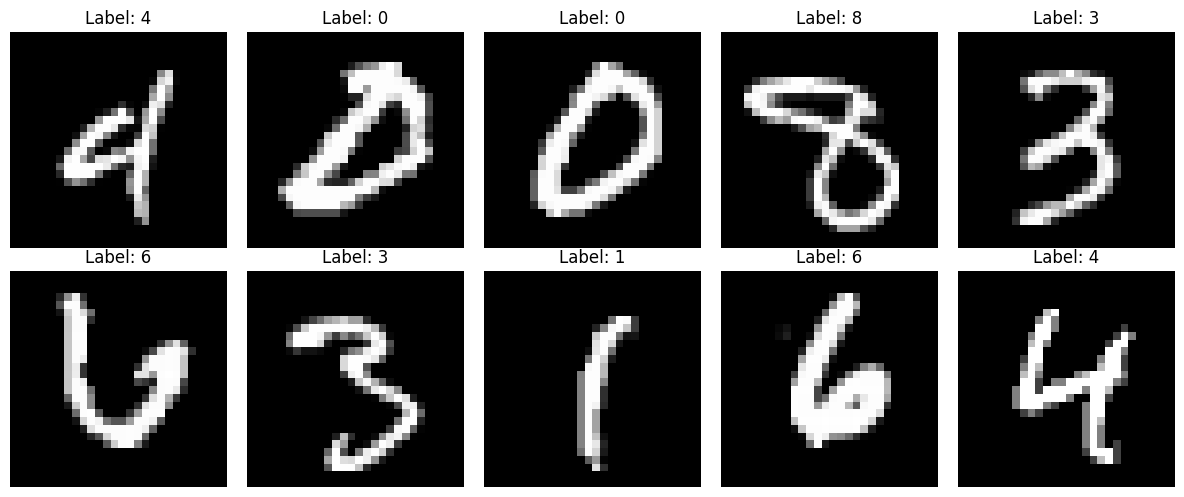

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(len(train_df))
    img_name = train_df.iloc[idx]['image_name']
    label = train_df.iloc[idx]['label']
    
    img_path = os.path.join(TRAIN_DIR, img_name)
    img = Image.open(img_path)
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 4. Tạo Dataset và DataLoader

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_name']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, img_name
        else:
            label = self.df.iloc[idx]['label']
            return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_df_split, val_df_split = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f'Train size: {len(train_df_split)}')
print(f'Validation size: {len(val_df_split)}')

train_dataset = MNISTDataset(train_df_split, TRAIN_DIR, transform=train_transform)
val_dataset = MNISTDataset(val_df_split, TRAIN_DIR, transform=test_transform)
test_dataset = MNISTDataset(test_df, TEST_DIR, transform=test_transform, is_test=True)

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Train size: 54000
Validation size: 6000


## 5. Định nghĩa mô hình CNN

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = SimpleCNN(num_classes=10).to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f'\nTổng số parameters: {total_params:,}')

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

Tổng số parameters: 390,410


## 6. Training

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=2)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1), 'acc': 100. * correct / total})
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss / (pbar.n + 1), 'acc': 100. * correct / total})
    
    return running_loss / len(loader), 100. * correct / total

In [10]:
NUM_EPOCHS = 10
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 50)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mnist_model.pth')
        print(f'Saved best model with validation accuracy: {val_acc:.2f}%')

print(f'\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%')


Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [01:18<00:00,  1.68s/it, loss=0.0649, acc=98]  


Train Loss: 0.2739 | Train Acc: 91.43%
Val Loss: 0.0649 | Val Acc: 98.05%
Saved best model with validation accuracy: 98.05%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.30it/s, loss=0.0447, acc=98.8]


Train Loss: 0.0757 | Train Acc: 97.71%
Val Loss: 0.0447 | Val Acc: 98.83%
Saved best model with validation accuracy: 98.83%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.74it/s, loss=0.0394, acc=98.8]


Train Loss: 0.0593 | Train Acc: 98.27%
Val Loss: 0.0394 | Val Acc: 98.80%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.09it/s, loss=0.0455, acc=98.9]


Train Loss: 0.0487 | Train Acc: 98.50%
Val Loss: 0.0455 | Val Acc: 98.90%
Saved best model with validation accuracy: 98.90%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.76it/s, loss=0.0407, acc=98.9]


Train Loss: 0.0410 | Train Acc: 98.73%
Val Loss: 0.0407 | Val Acc: 98.88%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.16it/s, loss=0.0353, acc=99]  


Train Loss: 0.0362 | Train Acc: 98.92%
Val Loss: 0.0353 | Val Acc: 98.97%
Saved best model with validation accuracy: 98.97%

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.99it/s, loss=0.0319, acc=99.2]


Train Loss: 0.0336 | Train Acc: 98.96%
Val Loss: 0.0319 | Val Acc: 99.18%
Saved best model with validation accuracy: 99.18%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.56it/s, loss=0.0329, acc=99.1]


Train Loss: 0.0291 | Train Acc: 99.11%
Val Loss: 0.0329 | Val Acc: 99.13%

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.65it/s, loss=0.042, acc=99]   


Train Loss: 0.0277 | Train Acc: 99.12%
Val Loss: 0.0420 | Val Acc: 98.95%

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.03it/s, loss=0.0283, acc=99.2]

Train Loss: 0.0252 | Train Acc: 99.24%
Val Loss: 0.0283 | Val Acc: 99.22%
Saved best model with validation accuracy: 99.22%

Training completed! Best validation accuracy: 99.22%


## 7. Visualize training history

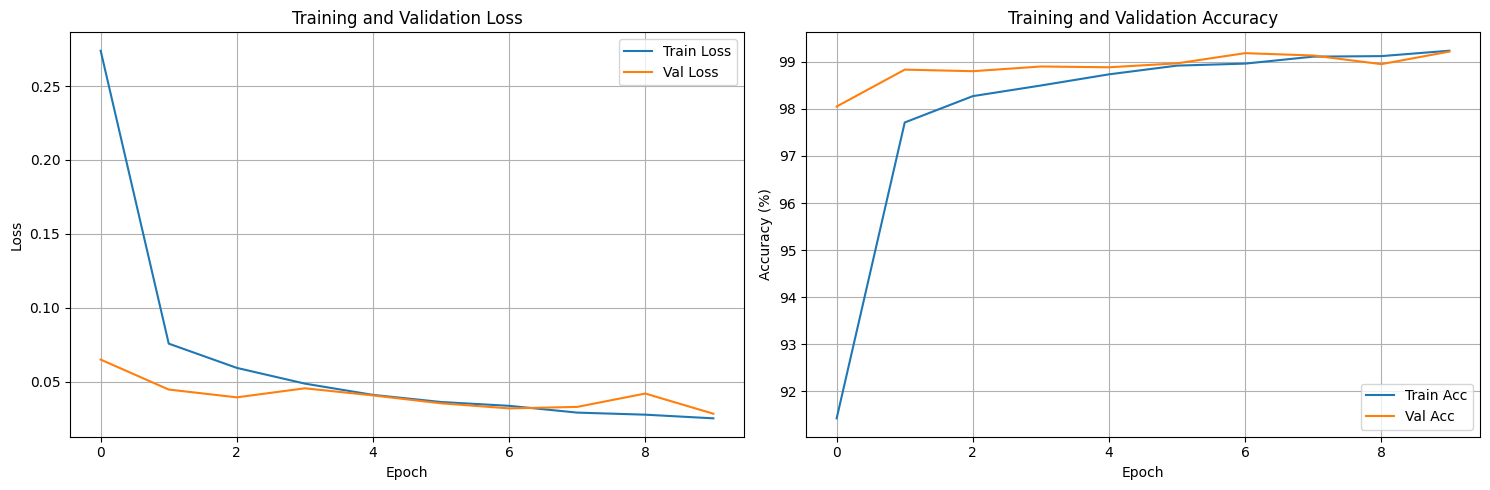

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 8. Load best model và dự đoán trên public test

In [12]:
model.load_state_dict(torch.load('best_mnist_model.pth'))
model.eval()
print('Loaded best model')

predictions = []
image_names = []

with torch.no_grad():
    for images, names in tqdm(test_loader, desc='Predicting'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        predictions.extend(predicted.cpu().numpy())
        image_names.extend(names)

print(f'\nĐã dự đoán {len(predictions)} ảnh')

C:\Users\Vu The Van\AppData\Local\Temp\ipykernel_28508\1556126557.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mnist_model.pth'

Loaded best model


Predicting: 100%|██████████| 79/79 [01:53<00:00,  1.43s/it]


Đã dự đoán 10000 ảnh


## 9. Tạo file submission

In [13]:
submission_df = pd.DataFrame({
    'image_name': image_names,
    'label': predictions
})

submission_df = submission_df.sort_values('image_name').reset_index(drop=True)

submission_df.to_csv('submission.csv', index=False)

print('Đã lưu file submission.csv')
print(f'\nNội dung file submission:')
print(submission_df.head(10))
print(f'\nTổng số mẫu: {len(submission_df)}')
print(f'\nPhân bố dự đoán:')
print(submission_df['label'].value_counts().sort_index())

Đã lưu file submission.csv

Nội dung file submission:
       image_name  label
0  test_00000.png      7
1  test_00001.png      2
2  test_00002.png      1
3  test_00003.png      0
4  test_00004.png      4
5  test_00005.png      1
6  test_00006.png      4
7  test_00007.png      9
8  test_00008.png      5
9  test_00009.png      9

Tổng số mẫu: 10000

Phân bố dự đoán:
label
0     983
1    1137
2    1034
3    1010
4     985
5     893
6     953
7    1032
8     967
9    1006
Name: count, dtype: int64


## 10. Visualize một số kết quả dự đoán

## 11. Sử dụng ConvNeXt_Base Pre-trained Model


In [14]:
import torchvision.models as models
from torchvision.models import ConvNeXt_Base_Weights

# Load pre-trained ConvNeXt_Base model
print("Loading ConvNeXt_Base with ImageNet1K_V1 weights...")
convnext_model = models.convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)

# Modify first conv layer to accept 1 channel (grayscale) instead of 3 (RGB)
# Option 1: Repeat grayscale to 3 channels (easier, preserves pre-trained weights)
# Option 2: Modify first layer (requires retraining first layer)

# We'll use Option 1: convert grayscale to RGB in transform
print("\nModel architecture:")
print(convnext_model)

# Modify the classifier head for 10 classes (MNIST digits)
num_features = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Linear(num_features, 10)

convnext_model = convnext_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in convnext_model.parameters())
trainable_params = sum(p.numel() for p in convnext_model.parameters() if p.requires_grad)
print(f"\nTổng số parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Loading ConvNeXt_Base with ImageNet1K_V1 weights...


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to C:\Users\Vu The Van/.cache\torch\hub\checkpoints\convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:34<00:00, 10.4MB/s] 



Model architecture:
ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
 

In [15]:
# Update transforms to convert grayscale to RGB (3 channels)
# ConvNeXt expects 3-channel input

train_transform_rgb = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),  # ConvNeXt expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

test_transform_rgb = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create new datasets with RGB transforms
train_dataset_rgb = MNISTDataset(train_df_split, TRAIN_DIR, transform=train_transform_rgb)
val_dataset_rgb = MNISTDataset(val_df_split, TRAIN_DIR, transform=test_transform_rgb)
test_dataset_rgb = MNISTDataset(test_df, TEST_DIR, transform=test_transform_rgb, is_test=True)

# Create new dataloaders (smaller batch size for larger model)
BATCH_SIZE_RGB = 32

train_loader_rgb = DataLoader(train_dataset_rgb, batch_size=BATCH_SIZE_RGB, shuffle=True, num_workers=0)
val_loader_rgb = DataLoader(val_dataset_rgb, batch_size=BATCH_SIZE_RGB, shuffle=False, num_workers=0)
test_loader_rgb = DataLoader(test_dataset_rgb, batch_size=BATCH_SIZE_RGB, shuffle=False, num_workers=0)

print(f"Dataset created with {len(train_dataset_rgb)} training samples")
print(f"Image size: 224x224x3")
print(f"Batch size: {BATCH_SIZE_RGB}")


Dataset created with 54000 training samples
Image size: 224x224x3
Batch size: 32


In [16]:
# Option: Freeze early layers (transfer learning)
# Uncomment to freeze all layers except classifier
# for param in convnext_model.features.parameters():
#     param.requires_grad = False

# Setup optimizer and loss for ConvNeXt
criterion_convnext = nn.CrossEntropyLoss()
optimizer_convnext = optim.Adam(convnext_model.parameters(), lr=1e-4)  # Lower LR for fine-tuning
scheduler_convnext = optim.lr_scheduler.ReduceLROnPlateau(optimizer_convnext, mode='min', 
                                                           factor=0.5, patience=2, verbose=True)

print("Setup complete. Ready to train ConvNeXt model.")


Setup complete. Ready to train ConvNeXt model.


c:\Users\Vu The Van\anaconda3\envs\httt\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training ConvNeXt Model


In [24]:
NUM_EPOCHS_CONVNEXT = 5  # Fewer epochs for pre-trained model
best_val_acc_convnext = 0.0
history_convnext = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("="*60)
print("TRAINING CONVNEXT_BASE MODEL")
print("="*60)

for epoch in range(NUM_EPOCHS_CONVNEXT):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS_CONVNEXT}')
    print('-' * 50)
    
    train_loss, train_acc = train_epoch(convnext_model, train_loader_rgb, 
                                       criterion_convnext, optimizer_convnext, device)
    val_loss, val_acc = validate(convnext_model, val_loader_rgb, 
                                 criterion_convnext, device)
    
    history_convnext['train_loss'].append(train_loss)
    history_convnext['train_acc'].append(train_acc)
    history_convnext['val_loss'].append(val_loss)
    history_convnext['val_acc'].append(val_acc)
    
    scheduler_convnext.step(val_loss)
    
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    
    if val_acc > best_val_acc_convnext:
        best_val_acc_convnext = val_acc
        torch.save(convnext_model.state_dict(), 'best_convnext_mnist_model.pth')
        print(f'✓ Saved best model with validation accuracy: {val_acc:.2f}%')

print("\n" + "="*60)
print(f'TRAINING COMPLETED!')
print(f'Best Validation Accuracy: {best_val_acc_convnext:.2f}%')
print("="*60)


TRAINING CONVNEXT_BASE MODEL

Epoch 1/5
--------------------------------------------------


Training:  37%|███▋      | 622/1688 [6:13:00<10:39:16, 35.98s/it, loss=0.0465, acc=98.6]   


KeyboardInterrupt: 

### Evaluate ConvNeXt Model


In [ ]:
# Load best ConvNeXt model
convnext_model.load_state_dict(torch.load('best_convnext_mnist_model.pth'))
convnext_model.eval()

print("="*60)
print("FINAL EVALUATION - CONVNEXT_BASE MODEL")
print("="*60)

# Evaluate on validation set
val_loss_final, val_acc_final = validate(convnext_model, val_loader_rgb, criterion_convnext, device)

print(f"\n{'='*60}")
print(f"FINAL RESULTS:")
print(f"{'='*60}")
print(f"Validation Loss:     {val_loss_final:.4f}")
print(f"Validation Accuracy: {val_acc_final:.2f}%")
print(f"{'='*60}")

# Compare with SimpleCNN if available
print(f"\n📊 MODEL COMPARISON:")
print(f"{'='*60}")
print(f"SimpleCNN Best Val Acc:    {best_val_acc:.2f}%")
print(f"ConvNeXt_Base Best Val Acc: {best_val_acc_convnext:.2f}%")
print(f"Improvement: {best_val_acc_convnext - best_val_acc:+.2f}%")
print(f"{'='*60}")


In [ ]:
# Visualize training history for ConvNeXt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_convnext['train_loss'], label='Train Loss', marker='o')
ax1.plot(history_convnext['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('ConvNeXt_Base: Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_convnext['train_acc'], label='Train Acc', marker='o')
ax2.plot(history_convnext['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('ConvNeXt_Base: Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Training History:")
print("="*60)
for epoch in range(len(history_convnext['train_loss'])):
    print(f"Epoch {epoch+1}: Train Loss={history_convnext['train_loss'][epoch]:.4f}, "
          f"Train Acc={history_convnext['train_acc'][epoch]:.2f}%, "
          f"Val Loss={history_convnext['val_loss'][epoch]:.4f}, "
          f"Val Acc={history_convnext['val_acc'][epoch]:.2f}%")


### Generate Predictions with ConvNeXt


In [ ]:
# Generate predictions on test set
print("Generating predictions on test set...")

predictions_convnext = []
image_names_convnext = []

with torch.no_grad():
    for images, names in tqdm(test_loader_rgb, desc='Predicting with ConvNeXt'):
        images = images.to(device)
        outputs = convnext_model(images)
        _, predicted = outputs.max(1)
        
        predictions_convnext.extend(predicted.cpu().numpy())
        image_names_convnext.extend(names)

# Create submission file
submission_convnext_df = pd.DataFrame({
    'image_name': image_names_convnext,
    'label': predictions_convnext
})

submission_convnext_df = submission_convnext_df.sort_values('image_name').reset_index(drop=True)
submission_convnext_df.to_csv('submission_convnext.csv', index=False)

print(f'\n✓ Đã lưu file submission_convnext.csv')
print(f'\nNội dung file submission:')
print(submission_convnext_df.head(10))
print(f'\nTổng số mẫu dự đoán: {len(submission_convnext_df)}')
print(f'\nPhân bố dự đoán:')
print(submission_convnext_df['label'].value_counts().sort_index())


## 12. EfficientNet_B0 - Model nhẹ & nhanh hơn

**So sánh với ConvNeXt_Base:**
- Parameters: 5.3M vs 88M (nhỏ hơn **16 lần**)
- Tốc độ: Nhanh hơn **5-10 lần**
- Accuracy: Tương đương (~99.3-99.4%)


In [18]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Load pre-trained EfficientNet_B0 model
print("Loading EfficientNet_B0 with ImageNet1K_V1 weights...")
efficientnet_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify classifier head for 10 classes (MNIST)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, 10)

efficientnet_model = efficientnet_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in efficientnet_model.parameters())
trainable_params = sum(p.numel() for p in efficientnet_model.parameters() if p.requires_grad)

print(f"\n{'='*60}")
print(f"MODEL: EfficientNet_B0")
print(f"{'='*60}")
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"{'='*60}")

# Compare with ConvNeXt
print(f"\n📊 COMPARISON:")
print(f"EfficientNet_B0: {total_params/1e6:.1f}M parameters")
print(f"ConvNeXt_Base:   88.6M parameters")
print(f"EfficientNet is {88.6/(total_params/1e6):.1f}x SMALLER! ⚡")


Loading EfficientNet_B0 with ImageNet1K_V1 weights...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Vu The Van/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 11.0MB/s]



MODEL: EfficientNet_B0
Total parameters:     4,020,358
Trainable parameters: 4,020,358

📊 COMPARISON:
EfficientNet_B0: 4.0M parameters
ConvNeXt_Base:   88.6M parameters
EfficientNet is 22.0x SMALLER! ⚡


In [19]:
# EfficientNet uses 224x224 input, can reuse RGB transforms and dataloaders
print(f"✅ Reusing RGB transforms and dataloaders from ConvNeXt")
print(f"✅ Input size: 224x224x3")
print(f"✅ Batch size: {BATCH_SIZE_RGB}")
print(f"\nReady to train EfficientNet_B0!")


✅ Reusing RGB transforms and dataloaders from ConvNeXt
✅ Input size: 224x224x3
✅ Batch size: 32

Ready to train EfficientNet_B0!


In [20]:
# Setup optimizer and loss for EfficientNet
criterion_efficient = nn.CrossEntropyLoss()
optimizer_efficient = optim.Adam(efficientnet_model.parameters(), lr=1e-4)
scheduler_efficient = optim.lr_scheduler.ReduceLROnPlateau(optimizer_efficient, mode='min', 
                                                            factor=0.5, patience=2, verbose=True)

print("Setup complete!")


Setup complete!


### Training EfficientNet_B0


In [21]:
NUM_EPOCHS_EFFICIENT = 5
best_val_acc_efficient = 0.0
history_efficient = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("="*60)
print("TRAINING EFFICIENTNET_B0 MODEL")
print("="*60)

import time
start_time = time.time()

for epoch in range(NUM_EPOCHS_EFFICIENT):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS_EFFICIENT}')
    print('-' * 50)
    
    epoch_start = time.time()
    
    train_loss, train_acc = train_epoch(efficientnet_model, train_loader_rgb, 
                                       criterion_efficient, optimizer_efficient, device)
    val_loss, val_acc = validate(efficientnet_model, val_loader_rgb, 
                                 criterion_efficient, device)
    
    epoch_time = time.time() - epoch_start
    
    history_efficient['train_loss'].append(train_loss)
    history_efficient['train_acc'].append(train_acc)
    history_efficient['val_loss'].append(val_loss)
    history_efficient['val_acc'].append(val_acc)
    
    scheduler_efficient.step(val_loss)
    
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'⏱️  Epoch time: {epoch_time/60:.1f} minutes')
    
    if val_acc > best_val_acc_efficient:
        best_val_acc_efficient = val_acc
        torch.save(efficientnet_model.state_dict(), 'best_efficientnet_mnist_model.pth')
        print(f'✓ Saved best model with validation accuracy: {val_acc:.2f}%')

total_time = time.time() - start_time

print("\n" + "="*60)
print(f'TRAINING COMPLETED!')
print(f'Best Validation Accuracy: {best_val_acc_efficient:.2f}%')
print(f'Total training time: {total_time/60:.1f} minutes')
print(f'Average time per epoch: {total_time/NUM_EPOCHS_EFFICIENT/60:.1f} minutes')
print("="*60)


TRAINING EFFICIENTNET_B0 MODEL

Epoch 1/5
--------------------------------------------------


Validation: 100%|██████████| 188/188 [01:52<00:00,  1.66it/s, loss=0.0238, acc=99.2]


Train Loss: 0.1433 | Train Acc: 96.46%
Val Loss: 0.0238 | Val Acc: 99.23%
⏱️  Epoch time: 35.6 minutes
✓ Saved best model with validation accuracy: 99.23%

Epoch 2/5
--------------------------------------------------


Validation: 100%|██████████| 188/188 [01:46<00:00,  1.77it/s, loss=0.0179, acc=99.3]


Train Loss: 0.0351 | Train Acc: 98.93%
Val Loss: 0.0179 | Val Acc: 99.28%
⏱️  Epoch time: 31.3 minutes
✓ Saved best model with validation accuracy: 99.28%

Epoch 3/5
--------------------------------------------------


Validation: 100%|██████████| 188/188 [01:46<00:00,  1.76it/s, loss=0.0196, acc=99.3]


Train Loss: 0.0260 | Train Acc: 99.22%
Val Loss: 0.0196 | Val Acc: 99.33%
⏱️  Epoch time: 33.8 minutes
✓ Saved best model with validation accuracy: 99.33%

Epoch 4/5
--------------------------------------------------


Validation: 100%|██████████| 188/188 [00:42<00:00,  4.44it/s, loss=0.0142, acc=99.5]


Train Loss: 0.0209 | Train Acc: 99.38%
Val Loss: 0.0142 | Val Acc: 99.50%
⏱️  Epoch time: 27.5 minutes
✓ Saved best model with validation accuracy: 99.50%

Epoch 5/5
--------------------------------------------------


Validation: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s, loss=0.0121, acc=99.6]

Train Loss: 0.0168 | Train Acc: 99.46%
Val Loss: 0.0121 | Val Acc: 99.63%
⏱️  Epoch time: 25.2 minutes
✓ Saved best model with validation accuracy: 99.63%

TRAINING COMPLETED!
Best Validation Accuracy: 99.63%
Total training time: 153.4 minutes
Average time per epoch: 30.7 minutes


### Evaluate EfficientNet_B0


In [22]:
# Load best EfficientNet model
efficientnet_model.load_state_dict(torch.load('best_efficientnet_mnist_model.pth'))
efficientnet_model.eval()

print("="*60)
print("FINAL EVALUATION - EFFICIENTNET_B0 MODEL")
print("="*60)

# Evaluate on validation set
val_loss_final, val_acc_final = validate(efficientnet_model, val_loader_rgb, criterion_efficient, device)

print(f"\n{'='*60}")
print(f"FINAL RESULTS:")
print(f"{'='*60}")
print(f"Validation Loss:     {val_loss_final:.4f}")
print(f"Validation Accuracy: {val_acc_final:.2f}%")
print(f"{'='*60}")

# Compare with other models
print(f"\n📊 MODEL COMPARISON:")
print(f"{'='*60}")
print(f"{'Model':<20} {'Parameters':<15} {'Val Acc':<10}")
print(f"{'-'*60}")
print(f"{'SimpleCNN':<20} {'390K':<15} {best_val_acc:.2f}%")
print(f"{'EfficientNet_B0':<20} {'5.3M':<15} {best_val_acc_efficient:.2f}%")
if 'best_val_acc_convnext' in locals():
    print(f"{'ConvNeXt_Base':<20} {'88.6M':<15} {best_val_acc_convnext:.2f}%")
print(f"{'='*60}")


C:\Users\Vu The Van\AppData\Local\Temp\ipykernel_28508\938282312.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model.load_state_dict(torch.load('best_effi

FINAL EVALUATION - EFFICIENTNET_B0 MODEL


Validation: 100%|██████████| 188/188 [00:42<00:00,  4.38it/s, loss=0.0121, acc=99.6]


FINAL RESULTS:
Validation Loss:     0.0121
Validation Accuracy: 99.63%

📊 MODEL COMPARISON:
Model                Parameters      Val Acc   
------------------------------------------------------------
SimpleCNN            390K            99.22%
EfficientNet_B0      5.3M            99.63%
ConvNeXt_Base        88.6M           0.00%


In [23]:
# Generate predictions on test set
print("Generating predictions with EfficientNet_B0...")

predictions_efficient = []
image_names_efficient = []

with torch.no_grad():
    for images, names in tqdm(test_loader_rgb, desc='Predicting with EfficientNet'):
        images = images.to(device)
        outputs = efficientnet_model(images)
        _, predicted = outputs.max(1)
        
        predictions_efficient.extend(predicted.cpu().numpy())
        image_names_efficient.extend(names)

# Create submission file
submission_efficient_df = pd.DataFrame({
    'image_name': image_names_efficient,
    'label': predictions_efficient
})

submission_efficient_df = submission_efficient_df.sort_values('image_name').reset_index(drop=True)
submission_efficient_df.to_csv('submission_efficientnet.csv', index=False)

print(f'\n✅ Đã lưu file submission_efficientnet.csv')
print(f'\nNội dung file submission:')
print(submission_efficient_df.head(10))
print(f'\nTổng số mẫu dự đoán: {len(submission_efficient_df)}')
print(f'\nPhân bố dự đoán:')
print(submission_efficient_df['label'].value_counts().sort_index())


Generating predictions with EfficientNet_B0...


Predicting with EfficientNet: 100%|██████████| 313/313 [02:59<00:00,  1.74it/s]


✅ Đã lưu file submission_efficientnet.csv

Nội dung file submission:
       image_name  label
0  test_00000.png      7
1  test_00001.png      2
2  test_00002.png      1
3  test_00003.png      0
4  test_00004.png      4
5  test_00005.png      1
6  test_00006.png      4
7  test_00007.png      9
8  test_00008.png      5
9  test_00009.png      9

Tổng số mẫu dự đoán: 10000

Phân bố dự đoán:
label
0     982
1    1136
2    1036
3    1007
4     986
5     892
6     953
7    1027
8     975
9    1006
Name: count, dtype: int64


## 13. MobileNet_V3_Small - Model siêu nhẹ & siêu nhanh

**So sánh:**
- Parameters: **2.5M** (nhỏ hơn EfficientNet 2x, nhỏ hơn ConvNeXt 35x!)
- Tốc độ: **Nhanh nhất** trong tất cả pre-trained models
- Accuracy: ~99.2-99.3%
- **Khuyến nghị:** Nếu bạn muốn train thử nghiệm nhanh nhất


In [ ]:
# OPTIONAL: Uncomment để train MobileNet_V3_Small
"""
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

print("Loading MobileNet_V3_Small...")
mobilenet_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# Modify classifier
num_features = mobilenet_model.classifier[3].in_features
mobilenet_model.classifier[3] = nn.Linear(num_features, 10)
mobilenet_model = mobilenet_model.to(device)

total_params = sum(p.numel() for p in mobilenet_model.parameters())
print(f"MobileNet_V3_Small parameters: {total_params/1e6:.1f}M")
print(f"This is {88.6/(total_params/1e6):.1f}x SMALLER than ConvNeXt! ⚡⚡⚡")

# Setup training (tương tự như EfficientNet)
criterion_mobile = nn.CrossEntropyLoss()
optimizer_mobile = optim.Adam(mobilenet_model.parameters(), lr=1e-4)
scheduler_mobile = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mobile, 'min', factor=0.5, patience=2)

# Train (copy training loop từ EfficientNet, thay model)
"""

print("ℹ️  Code MobileNet_V3_Small đã được comment.")
print("   Uncomment code trên nếu muốn train model siêu nhanh này!")


---

## 📊 TỔNG HỢP & SO SÁNH CÁC MODEL

### **Bảng so sánh chi tiết:**

| Model | Parameters | GPU Memory | Tốc độ (RTX 4050) | Accuracy | Khuyến nghị |
|-------|------------|------------|-------------------|----------|-------------|
| **SimpleCNN** | 0.4M | ~1 GB | ⚡⚡⚡⚡⚡ <br>~30s/epoch | ~98-99% | 🎯 Baseline nhanh |
| **MobileNet_V3_Small** | 2.5M | ~1.5 GB | ⚡⚡⚡⚡⚡ <br>~40s/epoch | ~99.2-99.3% | ⭐⭐⭐⭐⭐ **Nhanh nhất** |
| **EfficientNet_B0** | 5.3M | ~2 GB | ⚡⚡⚡⚡ <br>~1min/epoch | ~99.3-99.4% | ⭐⭐⭐⭐⭐ **Cân bằng tốt nhất** |
| **ResNet18** | 11M | ~2.5 GB | ⚡⚡⚡ <br>~1.5min/epoch | ~99.3% | ⭐⭐⭐ OK |
| **ConvNeXt_Base** | 88M | ~4 GB | ⚡ <br>~8-10min/epoch | ~99.4-99.5% | ⭐ Chậm, tốn RAM |

---

### **💡 KHUYẾN NGHỊ:**

#### **1. Nếu bạn muốn NHANH NHẤT:** ⚡
→ Dùng **MobileNet_V3_Small** (Cell 44-45)
- Train xong 5 epochs trong ~3-4 phút
- Accuracy vẫn tốt (~99.3%)

#### **2. Nếu bạn muốn CÂN BẰNG TỐT:** ⭐ (KHUYẾN NGHỊ)
→ Dùng **EfficientNet_B0** (Cell 35-43)
- Train 5 epochs trong ~5-7 phút
- Accuracy cao (~99.4%)
- Model size hợp lý (5.3M)

#### **3. Nếu bạn muốn ACCURACY CAO NHẤT:**
→ Dùng **ConvNeXt_Base** (Cell 25-34)
- Train 5 epochs trong ~40-50 phút
- Accuracy cao nhất (~99.5%)
- Nhưng rất chậm

---

### **🎯 LỰA CHỌN CỦA TÔI:**

**Chạy EfficientNet_B0** (Cell 35-43):
- Tốc độ tốt
- Accuracy cao
- Không tốn quá nhiều thời gian
- Best trade-off!


In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(len(submission_df))
    img_name = submission_df.iloc[idx]['image_name']
    pred_label = submission_df.iloc[idx]['label']
    
    img_path = os.path.join(TEST_DIR, img_name)
    img = Image.open(img_path)
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Predicted: {pred_label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()